# Yule-Simpson's paradox data generator

- toc: true 
- badges: true
- comments: false
- categories: [r,ggplot,recipes,simpson]


*TOC*
* write a function for generating Yule-Simpson's paradox dataset(s)


 



For a detailed description of Simpson paradox (and also to see it in a different than usual contest) I suggest to read "Spanos, A. Yule–Simpson’s paradox: the probabilistic versus the empirical conundrum . Stat Methods Appl 30, 605–635 (2021). https://doi.org/10.1007/s10260-020-00536-4"
Since this is a just a blog I prefer to show you some plots. 
First of all we load `datasaurus` library and then we load the simpson dataset and we plot it with the help of `ggplot`

obligatory references:

Simpson, E.H. (1951), The Interpretation of Interaction in Contingency Tables. Journal of the Royal Statistical Society: Series B (Methodological), 13: 238-241. https://doi.org/10.1111/j.2517-6161.1951.tb00088.x

G. UNDY YULE, NOTES ON THE THEORY OF ASSOCIATION OF ATTRIBUTES IN STATISTICS, Biometrika, Volume 2, Issue 2, February 1903, Pages 121–134, https://doi.org/10.1093/biomet/2.2.121

Matejka, J., & Fitzmaurice, G. (2017). Same Stats, Different Graphs: Generating Datasets with Varied Appearance and Identical Statistics through Simulated Annealing. CHI 2017 Conference proceedings: ACM SIGCHI Conference on Human Factors in Computing Systems. Retrieved from https://www.autodeskresearch.com/publications/samestats.

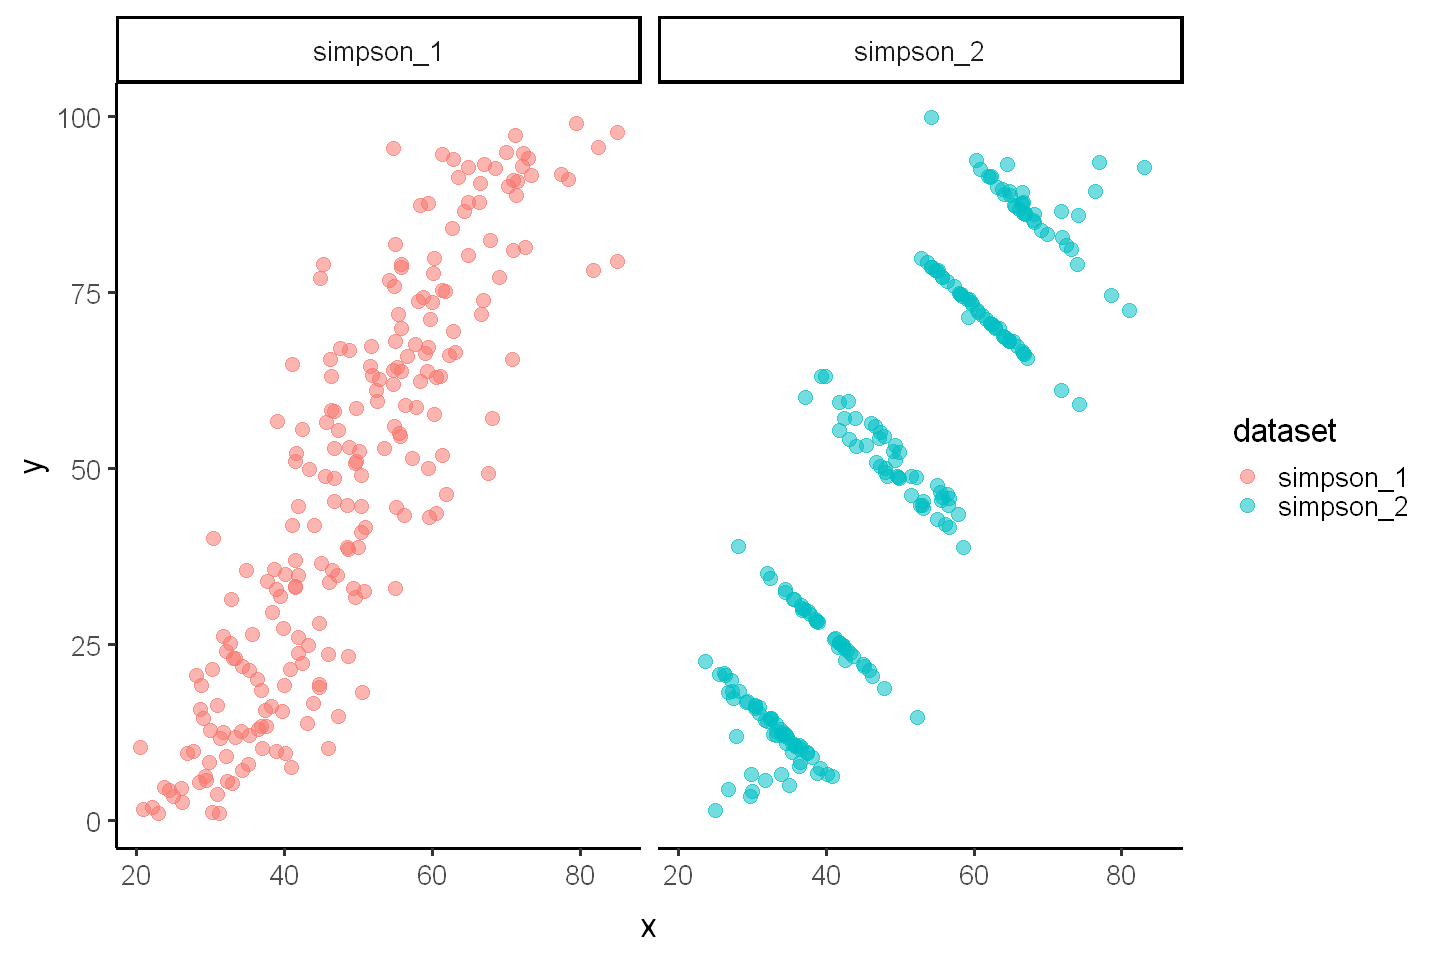

In [6]:
library(data.table)
library(ggplot2)
library(datasauRus)

options(repr.plot.width=12, repr.plot.height=8)

if(require(ggplot2)){
  p <-  ggplot(simpsons_paradox, aes(x=x, y=y, colour=dataset))+
    geom_point(size=4,alpha=0.55)+
    theme(legend.position = "none")+
    facet_wrap(~dataset, ncol=3)
}

p + theme_classic(base_size = 20)

what you are seing is (from the description) "A dataset demonstrating Simpson's Paradox with a strongly positively correlated dataset (simpson_1) and a dataset with the same positive correlation as simpson_1, but where individual groups have a strong negative correlation (simpson_2)". 
So is it possible to write a function to create random Yule-Simpson's paradox dataset? Let's try it (but first of all we add a regression line as shown in https://stackoverflow.com/a/15654715/6483091 and https://stackoverflow.com/a/37504482/6483091


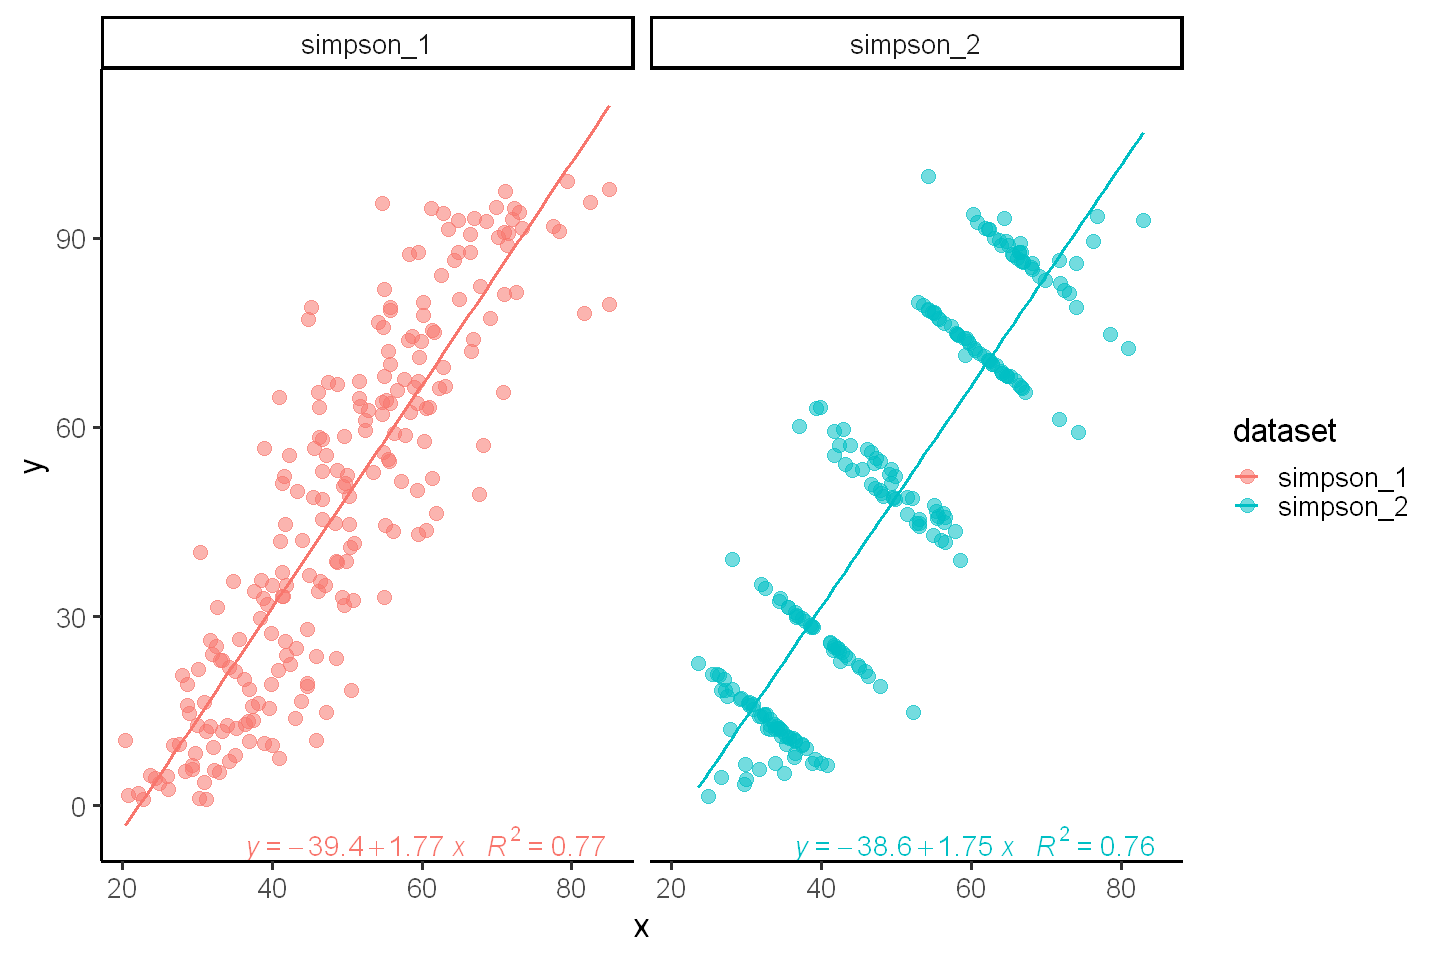

In [23]:

library(ggpmisc)
method <- y ~ x
pp <- ggplot(simpsons_paradox, aes(x= x, y= y, color = dataset)) +
  geom_point(size=4,alpha=0.55) +
  facet_wrap(~dataset, ncol=3)  +
  geom_smooth(method = "lm", formula = formula, se = F) +
  stat_poly_eq(aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~")), 
               label.x.npc = "right", label.y.npc = -1,
               formula = method, parse = TRUE, size = 6)
pp + theme_classic(base_size = 20)


the strategy that we will follow is simple. and it is again very "brutal" and not formal at all. the idea is 
1. create a starting and ending x for the x y dataset we are creating
2. (add noise)
3. divide in n intervals/step the xend-xstart 
4. create distributions (normal, uniform, gaussian,whatever) for each step
5. rotate all the distributions (simple trigonometry)
the code is the following, but again plots will better explain the strategy
Before implementing the step we try to see how to create a distribution and rotate it

Warning message in x * cos(pi * theta):
"longer object length is not a multiple of shorter object length"
Warning message in y * sin(pi * theta):
"longer object length is not a multiple of shorter object length"
Warning message in x * sin(pi * theta):
"longer object length is not a multiple of shorter object length"
Warning message in y * cos(pi * theta):
"longer object length is not a multiple of shorter object length"


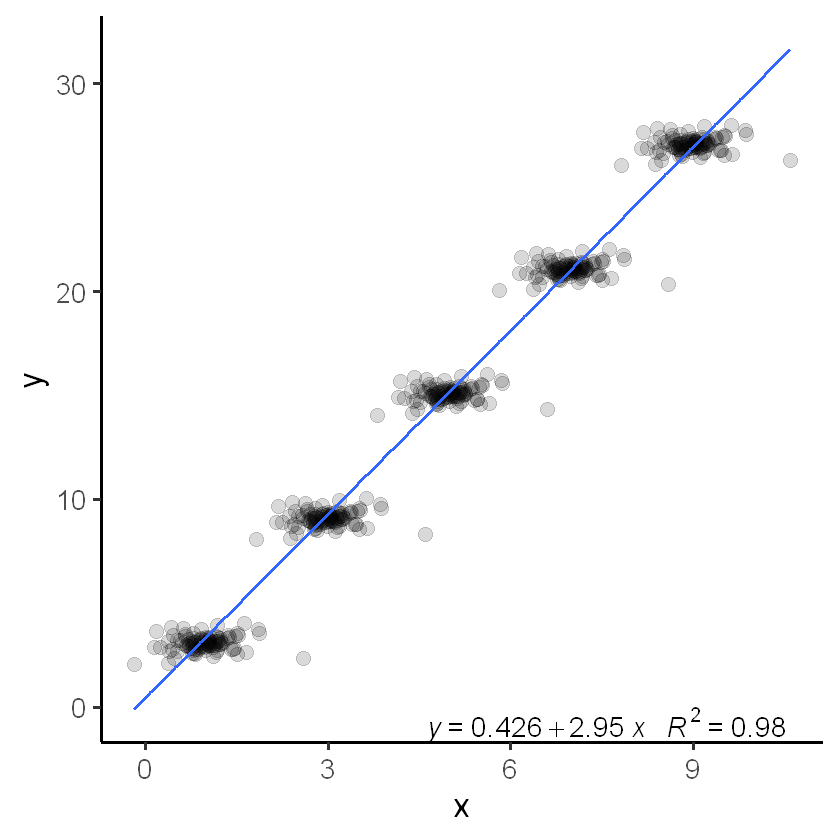

In [5]:
library(data.table)
library(foreach)
library(ggpmisc)

points_dist=100
theta=seq(-1,1,0.1)


x <- rnorm(points_dist,0,0.5)
y <- rnorm(points_dist,0,0.2)

xi <- x*cos(pi*theta)-y*sin(pi*theta)
yi <- x*sin(pi*theta)-y*cos(pi*theta)

m=3
xstart=1
xend=10
xseq <- seq(xstart,xend,2)
yseq <- m*xseq
library(foreach)

xsimp <- foreach(i=1:length(xseq)) %do%  { xseq[i]+xi }
ysimp <- foreach(i=1:length(yseq)) %do%  { yseq[i]+yi }
xysimp <- data.table(unlist(xsimp),unlist(ysimp))
colnames(xysimp) <- c("x","y")

method <- y ~ x
p2 <- ggplot(xysimp, aes(x= x, y= y)) +
  geom_point(size=4,alpha=0.15) +
  geom_smooth(method = "lm", formula = method, se = F) +
  stat_poly_eq(aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~")), 
               label.x.npc = "right", label.y.npc = -1,
               formula = method, parse = TRUE, size = 6)


p2 + theme_classic(base_size = 20)

note: I used the base plot since it is was faster for me for prototyping amd inserting it in a loop the trick for creating the colors is taken from  https://rjbioinformatics.com/2016/07/10/creating-color-palettes-in-r/ and http://www.colbyimaging.com/wiki/statistics/color-bars. now we are ready to test this snippets to create a simpson plot

ok it seems to work. Let's wrap it in a function

In [6]:
library(data.table)
#we now write everything in form of a function
yulsim <- function(m=3,xstart=1,xend=10,theta=-0.3,step=0.5,nfx=0.1,nfy=0.5,npoints=100,coeff=2){
            x <- rnorm(npoints,0,nfx)
            y <- rnorm(npoints,0,nfy)

            xi <- x*cos(pi*theta)-y*sin(pi*theta)
            yi <- x*sin(pi*theta)-y*cos(pi*theta)

            m=m
            xstart=xstart
            xend=xend

            xseq <- seq(xstart,xend,step)
            yseq <- coeff + m*xseq
            library(foreach)

            xsimp <- foreach(i=1:length(xseq)) %do%  { xseq[i]+xi }
            ysimp <- foreach(i=1:length(yseq)) %do%  { yseq[i]+yi }
            ldat <- data.table(xsimp,ysimp)
            dat <- data.table(unlist(xsimp),unlist(ysimp))
            colnames(dat) <- c("x","y")
            my.list <- list("lout"=ldat,"out"=dat)
            return(my.list)
}

a few more test with ggplot

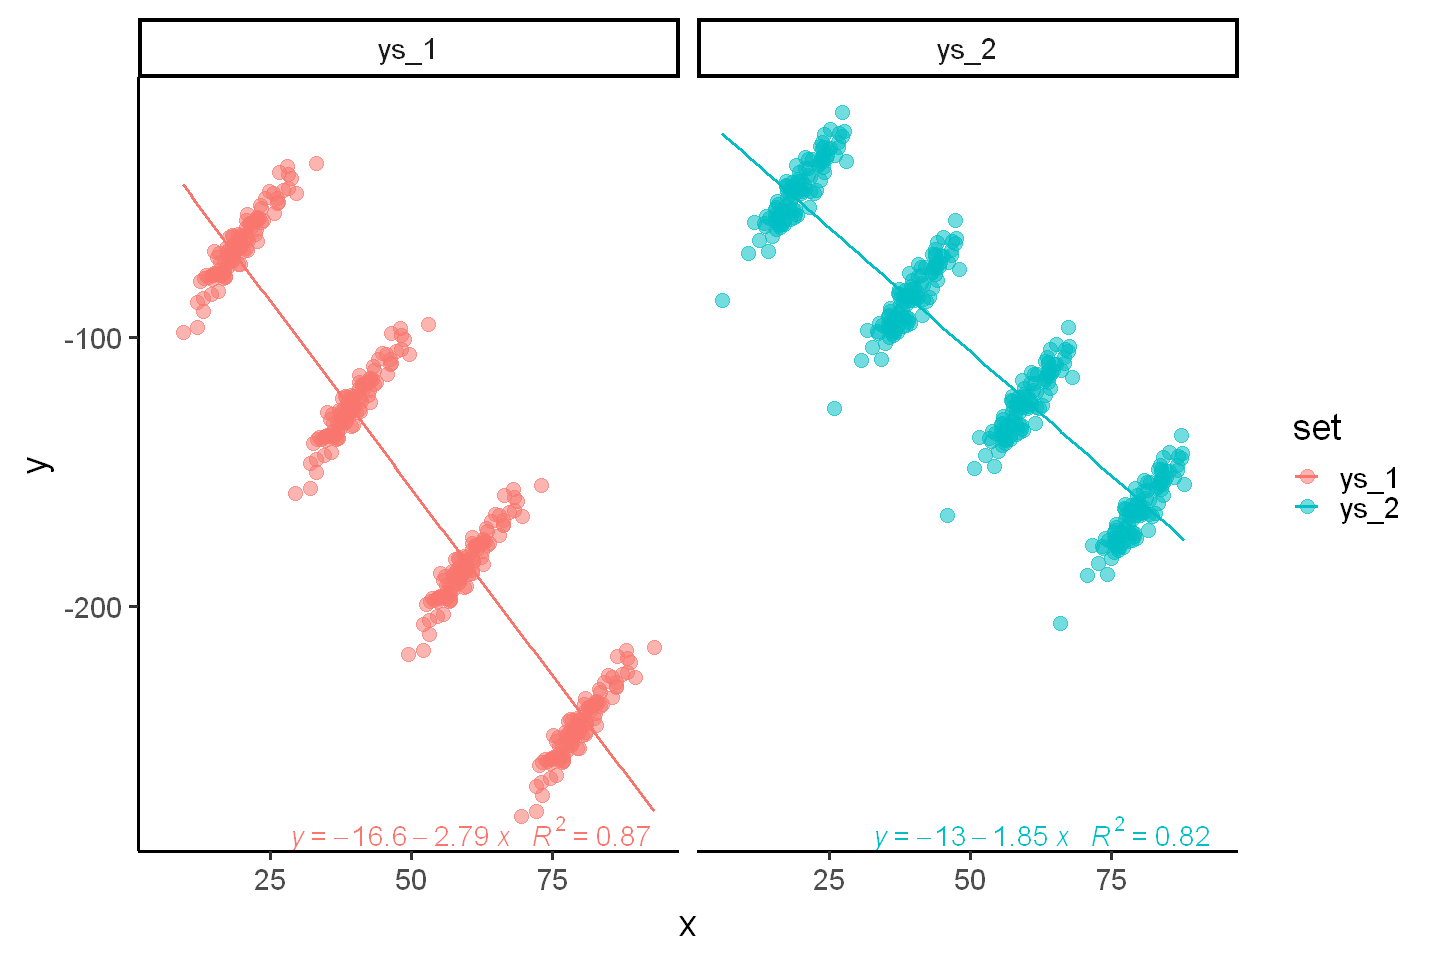

In [53]:

st1 <- yulsim (m=-3,xstart=20,xend=80,theta=0.4,step=20,nfx=12,nfy=2,npoints=100,coeff=-5)
st2 <- yulsim (m=-2,xstart=20,xend=80,theta=0.4,step=20,nfx=12,nfy=2,npoints=100,coeff=-5)


ys1 <- st1$out
ys2 <- st2$out


ys1$set <- "ys_1"
ys2$set <- "ys_2"


ysset <-  rbind(ys1,ys2)


p2 <-  ggplot(ysset, aes(x=x, y=y, colour=set))+
    geom_point(size=4,alpha=0.55)+
    theme(legend.position = "none")+
    facet_wrap(~set, ncol=2) +
	geom_smooth(method = "lm", formula = formula, se = F) +
	stat_poly_eq(aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~")), 
               label.x.npc = "right", label.y.npc = -1,
               formula = formula, parse = TRUE, size = 6)
p2 + theme_classic(base_size = 22)


and everything seems to work fine. The function is quite brutal, we can indeed change also the distributions used, but it is very flexible and does its job. so now we can generate as much as we want y-s dataset